# FIGURE 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns; sns.set(color_codes=True)
from msresist.pre_processing import preprocessing, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, CorrCoefFilter, FormatName, FormatSeq, TripsMeanAndStd, FilterByStdev
from msresist.sequence_analysis import GeneratingKinaseMotifs
from FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

## 1. Raw Phenotype Data

### 1.1 Cell Viability Measurements

In [2]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/viability.csv')
Y_cv = Y_cv.iloc[:10, 2]

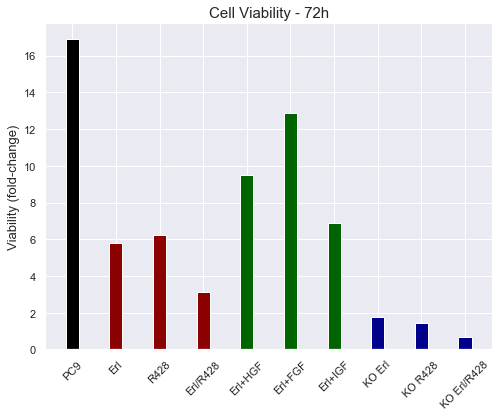

In [3]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
header = list(pd.read_csv('./msresist/data/Raw/20180817_JG_AM_TMT10plex_R1_psms_raw.csv', header=0).columns)
plt.bar(np.linspace(1,10,10)-1, Y_cv,width=0.3,align='center', color=['black', 'darkred', 'darkred', 'darkred', 'darkgreen', 'darkgreen', 'darkgreen', 'darkblue', 'darkblue', 'darkblue'])
plt.xticks(np.arange(10), (header[2:]), rotation=45)
plt.title("Cell Viability - 72h", fontsize=15)
plt.ylabel("Viability (fold-change)", fontsize = 13)
plt.show()

## 2. Raw Phosphorylation Measurements

In [4]:
A_r = pd.read_csv('./msresist/data/Raw/20180817_JG_AM_TMT10plex_R1_psms_raw.csv', header=0)
B_r = pd.read_csv('./msresist/data/Raw/20190214_JG_AM_PC9_AXL_TMT10_AC28_R2_PSMs_raw.csv', header=0)
C_r = pd.read_csv('./msresist/data/Raw/CombinedBR3_TR1&2_raw.csv', header=0)

ABC_mc = preprocessing(A_r, B_r, C_r, motifs=True, Vfilter=True, FCfilter=True, log2T=False)

In [5]:
print(ABC_mc.shape)
ABC_mc

(408, 12)


,peptide-phosphosite,Master Protein Descriptions,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428
0,RNPGFyVEANP,"1-phosphatidylinositol 4,5-bisphosphate phosph...",1.0,0.491785,0.766856,0.399749,0.535976,0.681548,0.386105,0.328710,0.787673,0.376014
1,QADVEyELRCL,MICAL-like protein 1,1.0,0.679539,0.337278,0.234240,0.683685,0.525853,0.656088,0.317062,0.441415,0.258164
2,TREPPyRVPRD,Matrin-3,1.0,0.593807,1.178802,0.507133,0.899395,0.439271,0.758562,0.509907,2.265228,0.246187
5,FMMtPyVVTRY,Mitogen-activated protein kinase 10,1.0,1.288490,0.551941,0.736386,1.007134,1.187766,1.124191,1.312259,2.484842,1.342552
6,TGYVAtRWYRA,Mitogen-activated protein kinase 11,1.0,1.499834,0.574639,1.422857,1.158584,1.226989,1.234786,1.657772,2.718082,1.650206
7,ADAEMtGYVVT,Mitogen-activated protein kinase 13,1.0,0.855382,0.517734,0.468916,0.733369,0.638775,0.636459,0.678397,0.747008,0.626940
8,EPPPPyVSA,Lysosomal-associated transmembrane protein 4B,1.0,0.833141,0.920334,0.505343,0.638839,0.541621,0.484578,0.817800,0.894664,0.459622
10,FMMtPyVVTRY,Mitogen-activated protein kinase 8,1.0,0.876928,0.918168,0.963270,1.311981,0.994368,1.313528,1.256538,2.657044,2.372301
14,YTGQPsPRGLH,Mitotic interactor and substrate of PLK1,1.0,1.279476,0.753839,0.413773,0.539797,0.534878,0.619431,0.650280,0.470593,0.938909
15,GTYEDyVEGLR,Myosin light polypeptide 6,1.0,0.803958,0.900769,0.495406,0.546496,0.577886,0.594445,0.544414,0.469731,0.468205


### 2.1 Clustergram

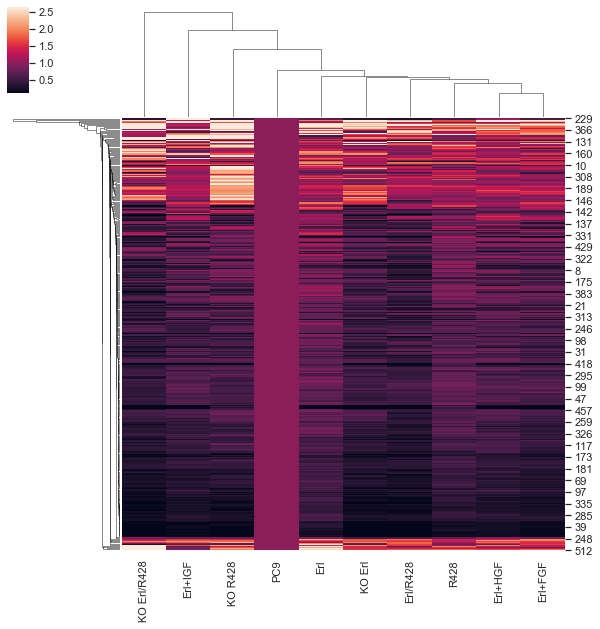

In [6]:
g = sns.clustermap(ABC_mc.iloc[:, 2:], method = "single", robust=True)
g

Clustergram Table:

In [7]:
p = g.dendrogram_row.reordered_ind
hm_prots = []
x = list(map(lambda v: hm_prots.append(ABC_mc.iloc[v, :]), p))
hm_prots = pd.DataFrame(hm_prots)

### 2.2 Pearson's heatmap 

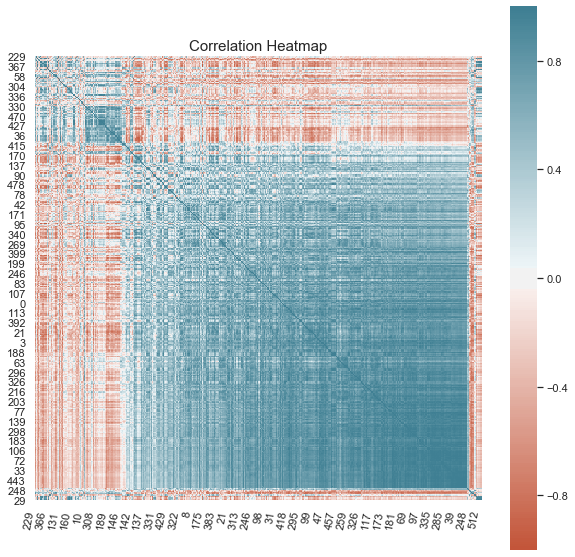

In [8]:
corr = ABC_mc.iloc[p, 2:].T.corr(method='pearson')
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.heatmap(corr,  vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80, horizontalalignment='right')
ax.set_title("Correlation Heatmap", fontsize=15);

### 2.3 Phosphorylation Status of Bypass RTKs

Look at the fold-change of canonical phosphorylation sites of bypass RTKs across conditions:

In [9]:
ABC = FoldChangeToControl(pd.concat([A_r, B_r, C_r]))

In [10]:
EGFR = ABC[ABC["peptide-phosphosite"].str.contains("gSHQISLDNPDyQQDFFPk-1")].mean()
IGFR = ABC[ABC["peptide-phosphosite"].str.contains("dIYETDYyR-1")].iloc[:, 2:].mean()
MET = ABC[ABC["peptide-phosphosite"].str.contains("dMYDkEyYSVHNk-1")].iloc[:, 2:].mean()
AXL = ABC[ABC["peptide-phosphosite"].str.contains("YNGDyYR-1")].iloc[:, 2:].mean()

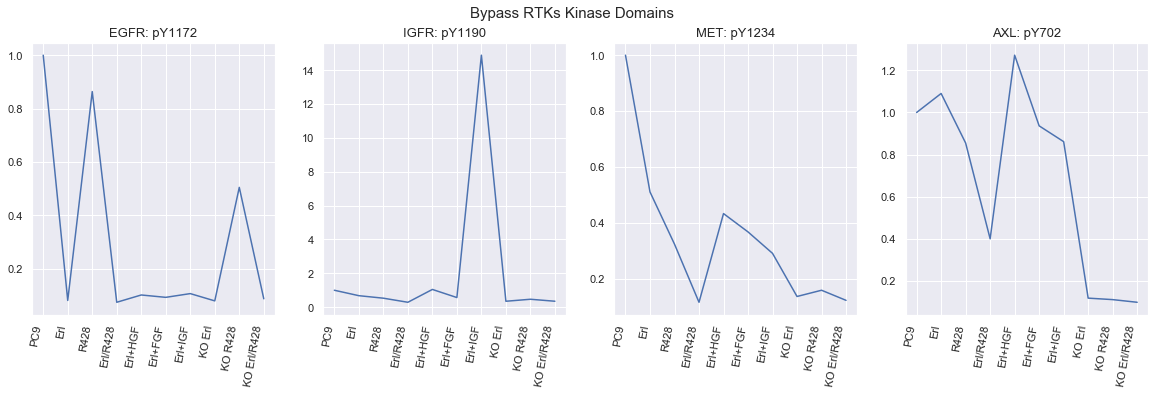

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].set_title("EGFR: pY1172", fontsize=13)
axs[0].plot(EGFR)
axs[0].set_xticklabels(header[2:], rotation=80, horizontalalignment='right')
axs[1].set_title("IGFR: pY1190", fontsize=13)
axs[1].plot(IGFR)
axs[1].set_xticklabels(header[2:], rotation=80, horizontalalignment='right')
axs[2].set_title("MET: pY1234", fontsize=13)
axs[2].plot(MET)
axs[2].set_xticklabels(header[2:], rotation=80, horizontalalignment='right')
axs[3].set_title("AXL: pY702", fontsize=13)
axs[3].plot(AXL)
axs[3].set_xticklabels(header[2:], rotation=80, horizontalalignment='right')
fig.suptitle('Bypass RTKs Kinase Domains', fontsize=15);

## 3. Variability across Replicates


Concatenated Raw Data:

In [12]:
ABC = FoldChangeToControl(pd.concat([A_r, B_r, C_r]))
ABC["Master Protein Descriptions"] = FormatName(ABC)

In [13]:
dups = pd.pivot_table(ABC, index=['Master Protein Descriptions', 'peptide-phosphosite'], aggfunc="size").sort_values()
dups_counter = {i: list(dups).count(i) for i in list(dups)}
dups_counter

{1: 620, 2: 246, 3: 128}

In [14]:
NonRecPeptides, CorrCoefPeptides, StdPeptides = MapOverlappingPeptides(ABC)

### 3.1 Grouping by Raw Sequences:

Duplicates:

In [15]:
DupsTable = BuildMatrix(CorrCoefPeptides, ABC)
DupsTable = CorrCoefFilter(DupsTable)
DupsTable_drop = DupsTable.drop_duplicates(["peptide-phosphosite", "Master Protein Descriptions"])
assert(DupsTable.shape[0]/2 == DupsTable_drop.shape[0])

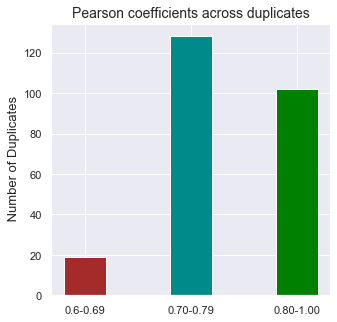

In [16]:
hi_conf = DupsTable_drop[DupsTable_drop["CorrCoefs"] >= 0.75]
med_conf = DupsTable_drop[(DupsTable_drop["CorrCoefs"] >= 0.70) | (DupsTable_drop["CorrCoefs"] < 0.75)]
low_conf = DupsTable_drop[DupsTable_drop["CorrCoefs"] < 0.70]
plt.figure(figsize=(5,5))
plt.bar(np.linspace(1,3,3), [low_conf.shape[0], med_conf.shape[0], hi_conf.shape[0]],width=0.4,align='center', color=['brown', 'darkcyan', 'green'], tick_label = ["0.6-0.69", "0.70-0.79", "0.80-1.00"])
plt.title("Pearson coefficients across duplicates", fontsize = 14)
plt.ylabel(" Number of Duplicates", fontsize = 13);

Triplicates:

In [17]:
StdPeptides = BuildMatrix(StdPeptides, ABC)
TripsTable = TripsMeanAndStd(StdPeptides, A_r.columns)
Stds = TripsTable.iloc[:, TripsTable.columns.get_level_values(1) == 'std']
Xidx = np.all(Stds.values <= 0.4, axis=1)
Stds = Stds.iloc[Xidx, :]

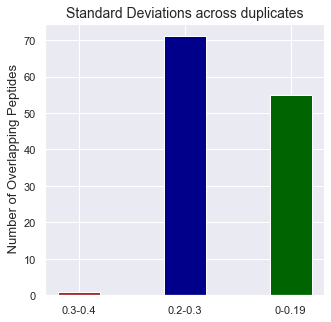

In [18]:
Std_mean = Stds.iloc[:, 1:].mean(axis=1)
hi_conf = Std_mean[Std_mean < 0.2]
med_conf = Std_mean[(Std_mean >= 0.2) | (Std_mean < 0.3)]
low_conf = Std_mean[Std_mean > 0.3]
plt.figure(figsize=(5,5))
plt.bar(np.linspace(1,3,3), [low_conf.shape[0], med_conf.shape[0], hi_conf.shape[0]],width=0.4,align='center', color=['brown', 'darkblue', 'darkgreen'], tick_label = ["0.3-0.4", "0.2-0.3", "0-0.19"])
plt.title("Standard Deviations across duplicates", fontsize = 14)
plt.ylabel(" Number of Overlapping Peptides", fontsize = 13);

### 3.2 Re-implementation grouping by motifs:

In [19]:
directory = "./msresist/data/Sequence_analysis/"
names, motifs = GeneratingKinaseMotifs(directory + "FaFile.fa", FormatName(ABC), FormatSeq(ABC), directory + "MatchedFaFile.fa", directory + "proteome_uniprot.fa")
ABC['peptide-phosphosite'] = motifs
ABC['Master Protein Descriptions'] = names

In [20]:
dups = pd.pivot_table(ABC, index=['Master Protein Descriptions', 'peptide-phosphosite'], aggfunc="size").sort_values()
dups_counter = {i: list(dups).count(i) for i in list(dups)}
dups_counter

{1: 516, 2: 228, 3: 106, 4: 24, 5: 11, 6: 8, 7: 1}

In [21]:
NonRecPeptides, CorrCoefPeptides, StdPeptides = MapOverlappingPeptides(ABC)

Duplicates:

In [22]:
DupsTable = BuildMatrix(CorrCoefPeptides, ABC)
DupsTable = CorrCoefFilter(DupsTable)
DupsTable_drop = DupsTable.drop_duplicates(["peptide-phosphosite", "Master Protein Descriptions"])
assert(DupsTable.shape[0]/2 == DupsTable_drop.shape[0])

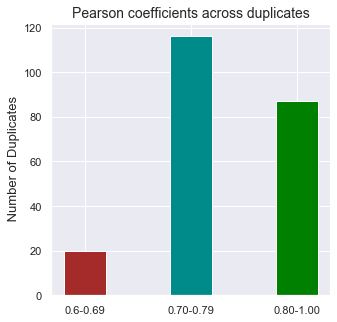

In [23]:
hi_conf = DupsTable_drop[DupsTable_drop["CorrCoefs"] >= 0.75]
med_conf = DupsTable_drop[(DupsTable_drop["CorrCoefs"] >= 0.70) | (DupsTable_drop["CorrCoefs"] < 0.75)]
low_conf = DupsTable_drop[DupsTable_drop["CorrCoefs"] < 0.70]
plt.figure(figsize=(5,5))
plt.bar(np.linspace(1,3,3), [low_conf.shape[0], med_conf.shape[0], hi_conf.shape[0]],width=0.4,align='center', color=['brown', 'darkcyan', 'green'], tick_label = ["0.6-0.69", "0.70-0.79", "0.80-1.00"])
plt.title("Pearson coefficients across duplicates", fontsize = 14)
plt.ylabel(" Number of Duplicates", fontsize = 13);

Triplicates:

In [24]:
StdPeptides = BuildMatrix(StdPeptides, ABC)
TripsTable = TripsMeanAndStd(StdPeptides, A_r.columns)
Stds = TripsTable.iloc[:, TripsTable.columns.get_level_values(1) == 'std']
Xidx = np.all(Stds.values <= 0.4, axis=1)
Stds = Stds.iloc[Xidx, :]

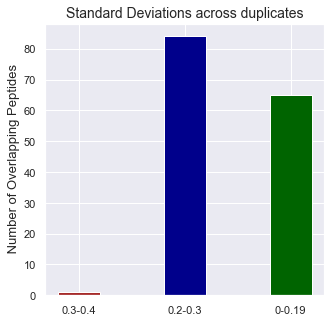

In [25]:
Std_mean = Stds.iloc[:, 1:].mean(axis=1)
hi_conf = Std_mean[Std_mean < 0.2]
med_conf = Std_mean[(Std_mean >= 0.2) | (Std_mean < 0.3)]
low_conf = Std_mean[Std_mean > 0.3]
plt.figure(figsize=(5,5))
plt.bar(np.linspace(1,3,3), [low_conf.shape[0], med_conf.shape[0], hi_conf.shape[0]],width=0.4,align='center', color=['brown', 'darkblue', 'darkgreen'], tick_label = ["0.3-0.4", "0.2-0.3", "0-0.19"])
plt.title("Standard Deviations across duplicates", fontsize = 14)
plt.ylabel(" Number of Overlapping Peptides", fontsize = 13);